In [250]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# !pip install pyLDAvis

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook

In [251]:
##Enter your csv path here
##Enter your csv path here
path="C:\\Users\\DELL\\Desktop\\hashtag\\pkp_tweet\\Code\\tweets_cleaned_13_04_23.csv"
df=pd.read_csv('/content/tweets_cleaned_13_04_23.csv')

In [252]:
#Creating the copy of the original dataframe incase
df_og = df.copy()

Number of articles per topic:


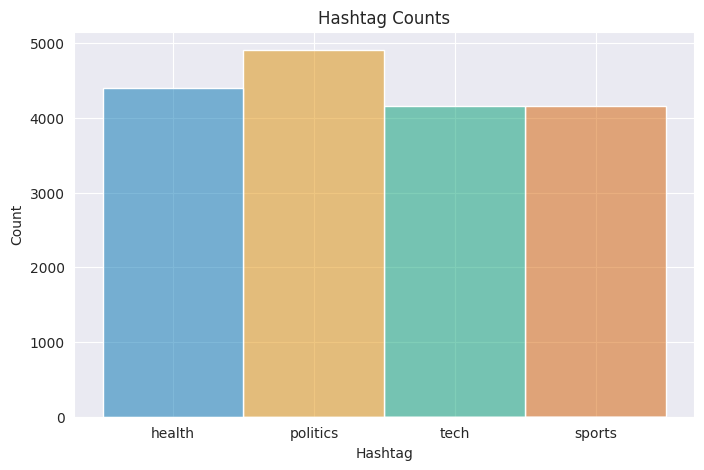

In [253]:
#To check the number of articles per topic if the topics are known
print('Number of articles per topic:')
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = df,
    x = 'Hashtag',
    hue = 'Hashtag',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Hashtag Counts');
# add_histogram_values(ax)
# C = pd.DataFrame(df['Hashtag'].value_counts())
# C

In [254]:
import nltk
from nltk.stem import *
nltk.download('punkt') # For Stemming
nltk.download('wordnet') # For Lemmatization
nltk.download('stopwords') # For Stopword Removal
nltk.download('omw-1.4')

#---------------------------------------
#Preprocess the tweets and returns a corpus(list of lists)
stop_words = set(stopwords.words('english'))
def text_preprocessing(df):
    corpus=[]

    lem = WordNetLemmatizer() # For Lemmatization
    for i in df['Tweet']:
        words=[w for w in nltk.tokenize.word_tokenize(i) if (w not in stop_words)] # word_tokenize function tokenizes text on each word by default
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [255]:
corpus=text_preprocessing(df)
print(f"length of corpus : {len(corpus)}\n type of corpus :{type(corpus)}")

length of corpus : 17639
 type of corpus :<class 'list'>


In [256]:
from gensim.models import word2vec
from gensim.models import FastText

In [257]:
#Training the word2vec model on our corpus with optimal parameters (found experimentally)
np.random.seed(0)
w2v_model = word2vec.Word2Vec(min_count=4,
                     window=2,
                     vector_size=100,
                     workers=4,
                     sg=1,
                     )

w2v_model.build_vocab(corpus, progress_per=10000)

w2v_model.train(corpus,
                total_examples=w2v_model.corpus_count,
                epochs=20, report_delay=1)


(5136380, 6165660)

In [258]:
#checking the vector embedding of a random word
(w2v_model.wv.__getitem__(['football']))

array([[ 0.06321663, -0.26312953,  0.10338794,  0.51153386,  0.30610228,
         0.18378866, -0.5270251 ,  0.29966235,  0.2065679 , -0.8628291 ,
        -0.43246084, -0.09961706, -0.58315736,  0.5663685 , -0.37339354,
         0.0770101 ,  0.6484303 ,  0.50615007, -0.0240373 , -1.1404059 ,
         0.53097373, -0.6248851 ,  1.1157562 , -0.45692956,  0.15928838,
        -0.11427244,  0.2675495 , -0.11268981, -0.19404112,  0.52789676,
         0.14015272, -0.23776977, -0.38924563,  0.39384678, -0.5438436 ,
         0.09084925, -0.00107038, -0.38145036, -0.08085425, -0.5955082 ,
         0.141637  , -0.45917755,  0.46694896, -0.5504654 ,  0.56409085,
         0.62647825, -0.3076418 , -0.4425054 , -0.01645209, -0.5046755 ,
         0.17973682, -0.20302728, -0.45654756, -0.19700424, -0.37881252,
        -0.08002736, -0.3623749 , -0.6849325 , -0.61061823,  0.20574999,
        -0.00737237, -0.5160466 ,  0.19033617,  0.1383966 , -0.58146363,
         0.8676186 , -0.3235135 , -0.20739165, -0.0

In [259]:
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 100 to 50 dimensions with PCA
    reduc = PCA(n_components=12).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=10).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

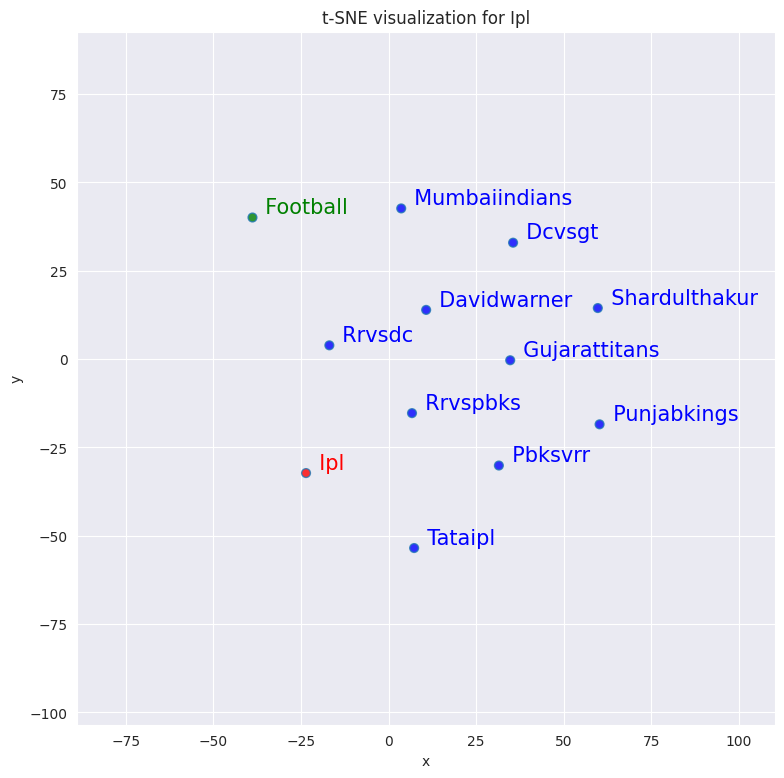

In [260]:
#10 similar and 1 random
tsnescatterplot(w2v_model, 'ipl',['football'])

In [261]:
#To extract the words from w2v model
words=w2v_model.wv.index_to_key
#to get the vector embeddings of the words into an array
model=w2v_model.wv.vectors
model.shape

(8037, 100)

In [262]:
#From the array with 8037(words)x100(dimensions)
# we apply SVD to reduce the dimension to 8037x30
from sklearn.decomposition import TruncatedSVD
n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_w2v = svd.fit_transform(model)
print(svd_w2v.shape)

#-----------------------------------------------
#Applying Tsne to w2v vectorizer model to reduce to 8037 x 2 and visualize the model
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_w2v = tsne_model.fit_transform(svd_w2v)

(8037, 30)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8037 samples in 0.001s...
[t-SNE] Computed neighbors for 8037 samples in 1.420s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8037
[t-SNE] Computed conditional probabilities for sample 2000 / 8037
[t-SNE] Computed conditional probabilities for sample 3000 / 8037
[t-SNE] Computed conditional probabilities for sample 4000 / 8037
[t-SNE] Computed conditional probabilities for sample 5000 / 8037
[t-SNE] Computed conditional probabilities for sample 6000 / 8037
[t-SNE] Computed conditional probabilities for sample 7000 / 8037
[t-SNE] Computed conditional probabilities for sample 8000 / 8037
[t-SNE] Computed conditional probabilities for sample 8037 / 8037
[t-SNE] Mean sigma: 0.358582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.284729
[t-SNE] KL divergence after 500 iterations: 2.726434


In [263]:
#creating the dataframe with words and it 2 dimensional vector embeddings
df=pd.DataFrame(tsne_w2v,columns=['x','y'])
df['word']=words
print(df)

              x          y           word
0     16.906927 -14.802857       politics
1     -7.125544   1.516080         health
2    -24.954063  16.444771     technology
3    -16.134819  -2.193326            amp
4     15.519084  16.033792          sport
...         ...        ...            ...
8032 -14.470031  11.332404         render
8033 -15.845319 -16.866325          avert
8034   3.154452 -21.032696         corbyn
8035  14.112008  -9.888754  walthamforest
8036  11.009640   8.016644           npfl

[8037 rows x 3 columns]


In [264]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600,
                       title="w2v clustering of the Tweet",
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [265]:
#Plotting of W2V model
# w2v_df = pd.DataFrame(svd_w2v, columns=['x', 'y'])
df['word'] = df['word']
plot_tfidf.scatter(x='x', y='y', source=df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@word"}
show(plot_tfidf)


In [266]:
#creating the minibatch clustering model
from sklearn.cluster import MiniBatchKMeans
np.random.seed(0)
num_clusters = 4 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               random_state=21,
                               n_init=25,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c"])

In [267]:
#fitting the kmeans model on (8037x2) dimension array
kmeans = kmeans_model.fit(tsne_w2v)
kmeans_clusters = kmeans.predict(tsne_w2v)
kmeans_distances = kmeans.transform(tsne_w2v)
# print(kmeans_distances.shape)
#again applying tsne as kmeans distances return 8037x4 array
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['word'] = df['word']
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the Tweet",
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    x_axis_type=None, y_axis_type=None, min_border=1)
source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    word=kmeans_df['word']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"word": "@word" }
show(plot_kmeans)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8037 samples in 0.006s...
[t-SNE] Computed neighbors for 8037 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8037
[t-SNE] Computed conditional probabilities for sample 2000 / 8037
[t-SNE] Computed conditional probabilities for sample 3000 / 8037
[t-SNE] Computed conditional probabilities for sample 4000 / 8037
[t-SNE] Computed conditional probabilities for sample 5000 / 8037
[t-SNE] Computed conditional probabilities for sample 6000 / 8037
[t-SNE] Computed conditional probabilities for sample 7000 / 8037
[t-SNE] Computed conditional probabilities for sample 8000 / 8037
[t-SNE] Computed conditional probabilities for sample 8037 / 8037
[t-SNE] Mean sigma: 1.359749
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.710114
[t-SNE] KL divergence after 500 iterations: 0.901791


In [268]:
kmeans_df

,x,y,cluster,word
0,21.261036,-36.351234,1,politics
1,-9.914584,2.834313,0,health
2,-29.208345,40.057011,0,technology
3,-24.985756,0.672401,3,amp
4,23.514292,19.959087,2,sport
...,...,...,...,...
8032,-15.935968,22.703249,0,render
8033,-29.235434,-23.897051,3,avert
8034,-2.009842,-38.127285,1,corbyn
8035,20.535416,-22.455214,1,walthamforest


['blockchain', 'crypto', 'nft', 'app', 'newyear', 'infographic', 'chatbot', 'pre', 'robotic', 'smartphone']


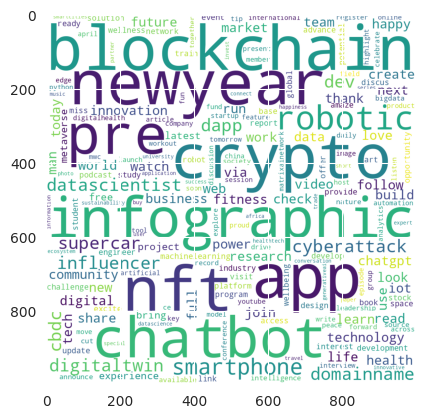

In [269]:
from wordcloud import WordCloud
from collections import Counter

# Generate or load your word cloud image
wc = WordCloud(width = 1000, height = 1000, min_font_size= 10, background_color='white')
cl0 = wc.generate(kmeans_df[kmeans_df['cluster'] == 0]['word'].str.cat(sep = ' '))


# Get the word frequencies from the word cloud image
word_frequencies = Counter(cl0.words_)

# Set the number of top words you want to extract
num_top_words = 10

# Extract the most frequent words
c0_pred_list =[]
for i in range(num_top_words):
  c0_pred_list.append(word_frequencies.most_common(num_top_words)[i][0])
print(c0_pred_list)
#generate the wordcloud
plt.imshow(cl0)

['biden', 'primeminister', 'mla', 'tmc', 'webcomic', 'dem', 'politics', 'day', 'year', 'people']


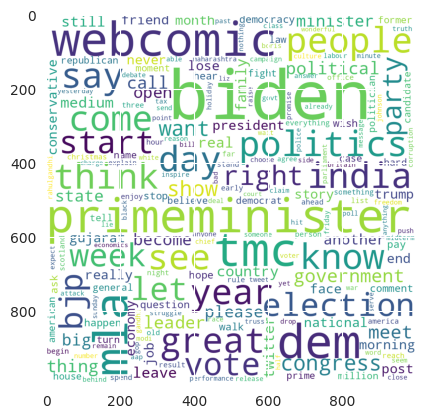

In [270]:
# Generate or load your word cloud image
wc = WordCloud(width = 1000, height = 1000, min_font_size= 10, background_color='white')
cl1 = wc.generate(kmeans_df[kmeans_df['cluster'] == 1]['word'].str.cat(sep = ' '))


# Get the word frequencies from the word cloud image
word_frequencies = Counter(cl1.words_)

# Set the number of top words you want to extract
num_top_words = 10

# Extract the most frequent words
c1_pred_list =[]
for i in range(num_top_words):
  c1_pred_list.append(word_frequencies.most_common(num_top_words)[i][0])
print(c1_pred_list)
#generate the wordcloud
plt.imshow(cl1)

['newsupdate', 'cricketlover', 'olympic', 'insidesport', 'cricketbat', 'soccerplayer', 'sport', 'ipl', 'football', 'cricket']


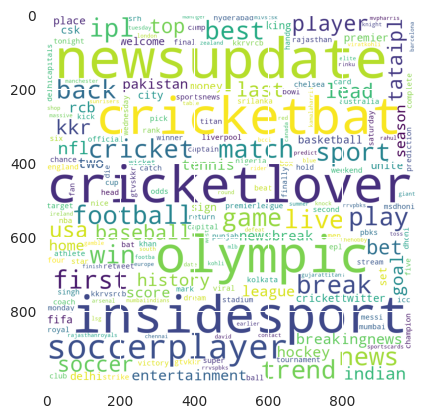

In [271]:
# Generate or load your word cloud image
wc = WordCloud(width = 1000, height = 1000, min_font_size= 10, background_color='white')
cl2 = wc.generate(kmeans_df[kmeans_df['cluster'] == 2]['word'].str.cat(sep = ' '))


# Get the word frequencies from the word cloud image
word_frequencies = Counter(cl2.words_)

# Set the number of top words you want to extract
num_top_words = 10

# Extract the most frequent words
c2_pred_list =[]
for i in range(num_top_words):
  c2_pred_list.append(word_frequencies.most_common(num_top_words)[i][0])
print(c2_pred_list)
#generate the wordcloud
plt.imshow(cl2)

['toward', 'alzheimer', 'genetic', 'psychedelic', 'diagnostic', 'medstudent', 'carb', 'amp', 'make', 'mentalhealth']


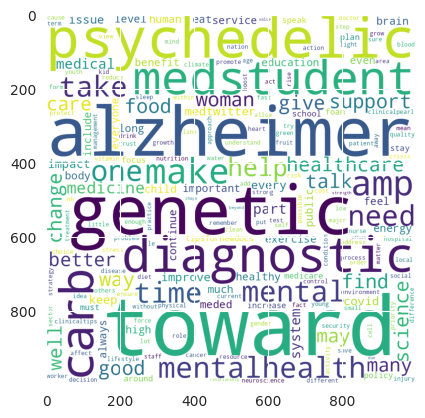

In [272]:
# Generate or load your word cloud image
wc = WordCloud(width = 1000, height = 1000, min_font_size= 10, background_color='white')
cl3 = wc.generate(kmeans_df[kmeans_df['cluster'] == 3]['word'].str.cat(sep = ' '))


# Get the word frequencies from the word cloud image
word_frequencies = Counter(cl3.words_)

# Set the number of top words you want to extract
num_top_words = 10

# Extract the most frequent words
c3_pred_list =[]
for i in range(num_top_words):
  c3_pred_list.append(word_frequencies.most_common(num_top_words)[i][0])
print(c3_pred_list)
#generate the wordcloud
plt.imshow(cl3)

In [273]:
def score_calc(pred_list):
  # Dictionary with categories and lists of words
  word_lists = {'health': ['health',
    'amp',
    'mentalhealth',
    'mental',
    'new',
    'life',
    'healthcare',
    'fitness',
    'get',
    'good'],
  'sports': ['sport',
    'ipl',
    'football',
    'cricket',
    'news',
    'match',
    'win',
    'vs',
    'game',
    'team'],
  'tech': ['technology',
    'ai',
    'blockchain',
    'innovation',
    'amp',
    'tech',
    'new',
    'web',
    'use',
    'future'],
  'politics': ['politics',
    'amp',
    'bjp',
    'vote',
    'people',
    'party',
    'congress',
    'say',
    'new',
    'news']}

  # List of words to compare with the dictionary
  word_list_to_compare = pred_list

  def jaccard_similarity(list1, list2):
      set1 = set(list1)
      set2 = set(list2)
      intersection = len(set1.intersection(set2))
      union = len(set1.union(set2))
      similarity = intersection / union
      return similarity

  # Calculate similarity between the word list and each category in the dictionary
  similarity_scores = {}
  for category, words in word_lists.items():
      # category_doc = nlp(" ".join(words))
      # word_list_doc = nlp(" ".join(word_list_to_compare))
      similarity_scores[category] = jaccard_similarity(word_list_to_compare, words)

  # Print the similarity scores
  for category, similarity_score in similarity_scores.items():
      print(f"Similarity with '{category}': {similarity_score:.4f}")


In [274]:
#for naming the clusetrs as the cluster 0 has most similarity with tech so we name cluster 0 as tech
score_calc(c0_pred_list)

Similarity with 'health': 0.0000
Similarity with 'sports': 0.0000
Similarity with 'tech': 0.0526
Similarity with 'politics': 0.0000


In [275]:
#calculating the coherence score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

topics=[]

# top_40_wrods_topic_0=top_40_wrods_topic_0
# top_40_wrods_topic_1=top_40_wrods_topic_1
# # top_40_wrods_topic_2=top_40_wrods_topic_2

topics.append(c0_pred_list)
topics.append(c1_pred_list)
topics.append(c2_pred_list)
topics.append(c3_pred_list)
print(topics)

# Creating a dictionary with the vocabulary
word2id = Dictionary( corpus )

# Coherence model
cm = CoherenceModel(topics=topics,
                    texts=corpus,
                    coherence='c_v',
                    dictionary=word2id)

coherence_per_topic = cm.get_coherence_per_topic()
coherence = cm.get_coherence()
print(coherence)

[['blockchain', 'crypto', 'nft', 'app', 'newyear', 'infographic', 'chatbot', 'pre', 'robotic', 'smartphone'], ['biden', 'primeminister', 'mla', 'tmc', 'webcomic', 'dem', 'politics', 'day', 'year', 'people'], ['newsupdate', 'cricketlover', 'olympic', 'insidesport', 'cricketbat', 'soccerplayer', 'sport', 'ipl', 'football', 'cricket'], ['toward', 'alzheimer', 'genetic', 'psychedelic', 'diagnostic', 'medstudent', 'carb', 'amp', 'make', 'mentalhealth']]
0.3699572960492961


In [276]:
df_og

,Unnamed: 0,Tweet,Hashtag
0,0,effect of anthocyanins on gut health markers f...,health
1,1,good news recently accept position as software...,health
2,2,start keto this month eat about lbs of pork be...,health
3,3,be healthy mean get whole lot more out of life...,health
4,4,butterfly welcome the feed govt announcement o...,health
...,...,...,...
17634,18496,the pakistan women football team have be annou...,sports
17635,18497,big ant studios and nacon cricket the official...,sports
17636,18498,list of injure players in ipl be increase day ...,sports
17637,18499,sport sponsorship cricket especially ipl domin...,sports


In [277]:
x = df_og.drop(columns = 'Hashtag')
y = df_og['Hashtag']


In [278]:
# Example list of categories
categories = ['tech', 'politics', 'sports', 'health']

# Create a mapping dictionary for manual encoding
encoding_map = {category: i for i, category in enumerate(categories)}

# Manually encode the categories
class_y = [encoding_map[category] for category in y]

In [279]:
class_y=np.array(class_y)

In [280]:
np.unique(y,return_counts=True)

(array(['health', 'politics', 'sports', 'tech'], dtype=object),
 array([4404, 4910, 4167, 4158]))

In [281]:
np.unique(class_y,return_counts=True)

(array([0, 1, 2, 3]), array([4158, 4910, 4167, 4404]))

In [282]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, class_y, test_size=0.3, random_state=42)

In [283]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(12347, 2)
(5292, 2)
(12347,)
(5292,)


In [284]:
x_test.iloc[0]

Unnamed: 0                                                17916
Tweet         what match it be rcb dominate mi in ipl thank ...
Name: 17118, dtype: object

In [285]:
x_test_corpus=text_preprocessing(x_test)

In [286]:
from scipy.spatial import distance
def prediction(tweet):
  existing_dicts= { 0: c0_pred_list,
                  1:c1_pred_list,
                  2:c2_pred_list,
                  3:c3_pred_list
                  }
  # existing_lists=[c0_pred_list,c1_pred_list,c2_pred_list,c3_pred_list]
  new_list=tweet
  def dict_to_vector(word_list, all_words):
      vector = np.zeros(len(all_words), dtype=int)
      for word in word_list:
          if word in all_words:
              vector[all_words.index(word)] = 1
      return vector

  # Collect all unique words from existing dictionaries and new list
  all_words = list(set().union(*existing_dicts.values(), new_list))

  # Convert the dictionaries to binary vectors
  existing_vectors = [dict_to_vector(lst, all_words) for lst in existing_dicts.values()]
  new_vector = dict_to_vector(new_list, all_words)
  # Calculate the Euclidean similarity scores between the new vector and each of the existing vectors
  similarity_scores = [distance.euclidean(new_vector, existing_vector) for existing_vector in existing_vectors]

  # Find the index of the most similar list (minimum similarity score)
  most_similar_index = np.argmin(similarity_scores)

  # Get the key (number) of the most similar list
  most_similar_key = list(existing_dicts.keys())[most_similar_index]

  # Print the most similar list
  return most_similar_key

In [287]:
# [pred for pred in ]
len(x_test_corpus)

5292

In [288]:
y_pred=[]
for i in range(len(x_test_corpus)):
  y_pred.append(prediction(x_test_corpus[i]))


In [289]:
len(y_pred)

5292

In [290]:
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report

In [291]:
a4=accuracy_score(y_test,y_pred)

In [292]:
a4

0.7683295540438397

In [293]:
print(y_pred[0])
print(y_test[0])

2
2


In [294]:
print(x_test_corpus[251])

['testis', 'epididymis', 'sagittal', 'view', 'anatomy', 'meded', 'medtwitter', 'testis', 'health']


In [295]:
print(x_test.iloc[20].Tweet)

so many cool statements about the at the cphia this be not just conference it be movement one that aim to highlight the good work be do in health in africa the co chair have do an amaze job ypc


In [296]:
cm = confusion_matrix(y_test, y_pred)

In [297]:
cm

array([[ 997,   97,    6,  169],
       [   8, 1447,    4,    7],
       [  13,   23, 1200,    0],
       [ 657,  230,   12,  422]])

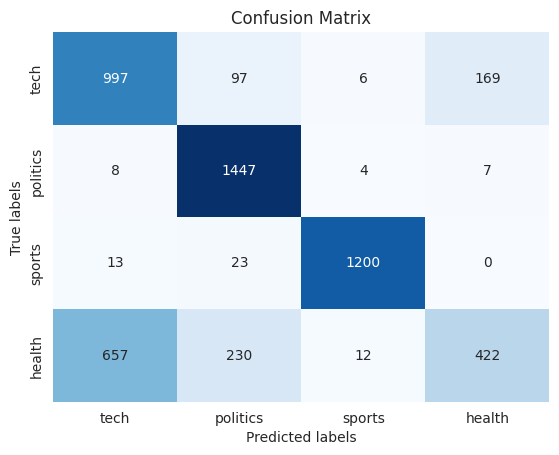

In [298]:
ax = plt.subplot()
labels = ['tech', 'politics', 'sports', 'health']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels = labels, yticklabels = labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()

In [299]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.79      0.68      1269
           1       0.81      0.99      0.89      1466
           2       0.98      0.97      0.98      1236
           3       0.71      0.32      0.44      1321

    accuracy                           0.77      5292
   macro avg       0.77      0.77      0.75      5292
weighted avg       0.77      0.77      0.75      5292



**Using cosine similarity**

In [300]:
# Original Dataset
df_og

,Unnamed: 0,Tweet,Hashtag
0,0,effect of anthocyanins on gut health markers f...,health
1,1,good news recently accept position as software...,health
2,2,start keto this month eat about lbs of pork be...,health
3,3,be healthy mean get whole lot more out of life...,health
4,4,butterfly welcome the feed govt announcement o...,health
...,...,...,...
17634,18496,the pakistan women football team have be annou...,sports
17635,18497,big ant studios and nacon cricket the official...,sports
17636,18498,list of injure players in ipl be increase day ...,sports
17637,18499,sport sponsorship cricket especially ipl domin...,sports


In [301]:
X = df_og.drop(columns = 'Hashtag')
y = df_og['Hashtag']

# Label Encoding

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
tweets_y = le.fit_transform(y)

In [302]:
# Label Mapping
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'health': 0, 'politics': 1, 'sports': 2, 'tech': 3}

In [303]:
# Spliting Data into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, tweets_y, test_size=0.30, random_state=0)

In [304]:
# Dictionary of clusters we made
dictionary = {'tech' : c0_pred_list, 'politics' : c1_pred_list, 'sports' : c2_pred_list, 'health' : c3_pred_list}
dictionary

{'tech': ['blockchain',
  'crypto',
  'nft',
  'app',
  'newyear',
  'infographic',
  'chatbot',
  'pre',
  'robotic',
  'smartphone'],
 'politics': ['biden',
  'primeminister',
  'mla',
  'tmc',
  'webcomic',
  'dem',
  'politics',
  'day',
  'year',
  'people'],
 'sports': ['newsupdate',
  'cricketlover',
  'olympic',
  'insidesport',
  'cricketbat',
  'soccerplayer',
  'sport',
  'ipl',
  'football',
  'cricket'],
 'health': ['toward',
  'alzheimer',
  'genetic',
  'psychedelic',
  'diagnostic',
  'medstudent',
  'carb',
  'amp',
  'make',
  'mentalhealth']}

In [305]:
# Classifying the test data based on cosine similarity score

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Set up NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Dataset of texts
dataset = X_test['Tweet'].tolist()

# Predefined dictionary of categories
categories = dictionary

# Remove stopwords and tokenize the dataset
tokenized_dataset = []
for text in dataset:
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]
    tokenized_dataset.append(filtered_words)

# Train Word2Vec model
model = Word2Vec(tokenized_dataset, min_count=1, vector_size=300, epochs=100)

# Calculate similarity of each text to the dictionary words
results = []
for text in dataset:
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]

    similarities = {}
    for category, words in categories.items():
        category_vectors = [model.wv[word] for word in words if word in model.wv.key_to_index]
        if category_vectors:
            category_similarity = sum(model.wv.n_similarity([category_vector], filtered_words) for category_vector in category_vectors)
            similarities[category] = category_similarity

    predicted_category = max(similarities, key=similarities.get)
    results.append((text, predicted_category))

# Create a dataframe with the text and classification
df_new = pd.DataFrame(results, columns=['Text', 'Classification'])
df_new


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Text,Classification
0,controversial confession ufc winner sam hughes...,sports
1,now on sdglive map our way out of water shorta...,tech
2,react politics cdnpoli canpol polcan canpoli s...,sports
3,and here to hope we emphasize mentalhealth as ...,health
4,finalize my last piece of write health lebanon,politics
...,...,...
5287,atchatasks dr mercedes himmons what do be an a...,health
5288,lebanese women don enter politics not cos we b...,politics
5289,innovation alert health innovation hackathon b...,tech
5290,ipl kkr spinners wreak havoc to hand rcb huge ...,sports


In [306]:
df_new['Classification'] = df_new.Classification.map({'health': 0, 'politics': 1, 'sports': 2, 'tech': 3})

In [307]:
# Checking the accuracy
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report
acc = accuracy_score(y_test, df_new.Classification)
cm = confusion_matrix(y_test, df_new.Classification)
acc, cm

(0.9000377928949358,
 array([[ 966,  175,   34,  104],
        [  35, 1396,   29,   20],
        [   1,   13, 1261,    8],
        [  54,   45,   11, 1140]]))

In [308]:
print(classification_report(y_test, df_new.Classification))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1279
           1       0.86      0.94      0.90      1480
           2       0.94      0.98      0.96      1283
           3       0.90      0.91      0.90      1250

    accuracy                           0.90      5292
   macro avg       0.90      0.90      0.90      5292
weighted avg       0.90      0.90      0.90      5292



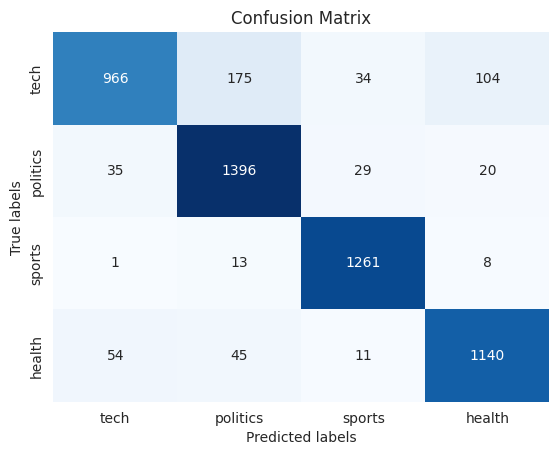

In [309]:
ax = plt.subplot()
labels = ['tech', 'politics', 'sports', 'health']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels = labels, yticklabels = labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()

In [310]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Set up NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# Dataset of texts
#dataset = x_test['Tweet'].tolist()

def prediction_model(dataset):

  # Predefined dictionary of categories
  categories = dictionary

  # Remove stopwords and tokenize the dataset
  tokenized_dataset = []
  for text in dataset:
      tokens = word_tokenize(text.lower())
      filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]
      tokenized_dataset.append(filtered_words)

  # Train Word2Vec model
  model = Word2Vec(tokenized_dataset, min_count=1, vector_size=300, epochs=100)

  # Calculate similarity of each text to the dictionary words
  results = []
  for text in dataset:
      tokens = word_tokenize(text.lower())
      filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]

      similarities = {}
      for category, words in categories.items():
          category_vectors = [model.wv[word] for word in words if word in model.wv.key_to_index]
          if category_vectors:
              category_similarity = sum(model.wv.n_similarity([category_vector], filtered_words) for category_vector in category_vectors)
              similarities[category] = category_similarity

      predicted_category = max(similarities, key=similarities.get)
      results.append((text, predicted_category))

  # Create a dataframe with the text and classification
  df_new = pd.DataFrame(results, columns=['Text', 'Classification'])
  df_new['Classification'] = df_new.Classification.map({'health': 0, 'politics': 1, 'sports': 2, 'tech': 3})
  return df_new

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [311]:
cml = []
accl = []
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(X, tweets_y, test_size=0.10)
  dataset = X_test['Tweet'].tolist()
  df_new1 = prediction_model(dataset)
  accl .append(accuracy_score(y_test, df_new1.Classification))
  cml.append(confusion_matrix(y_test, df_new1.Classification))

accl, cml

([0.7307256235827665,
  0.7125850340136054,
  0.8327664399092971,
  0.8934240362811792,
  0.7420634920634921],
 [array([[  3, 146,   4, 260],
         [  0, 468,   2,  17],
         [  0,   3, 402,  34],
         [  0,   8,   1, 416]]),
  array([[  1,  87,   4, 345],
         [  0, 426,  12,  35],
         [  0,   3, 413,  14],
         [  0,   6,   1, 417]]),
  array([[271, 132,   0,  55],
         [  6, 447,   4,  19],
         [  0,  22, 381,  39],
         [ 10,   8,   0, 370]]),
  array([[315,  78,   2,  24],
         [  3, 467,   5,  17],
         [  1,   6, 426,  14],
         [ 25,  11,   2, 368]]),
  array([[216,  59,   2, 171],
         [  1, 408,   1,  68],
         [  0,   1, 252, 148],
         [  0,   4,   0, 433]])])

In [312]:
from statistics import mean
mean(accl)

0.782312925170068